# Huggingface Sagemaker-sdk extension example using `Trainer` class

## Installs requirements if you haven´t already done it and sets up ipywidgets for datasets in sagemaker studio

In [10]:
%%capture
!pip install -r ../requirements.txt --upgrade

In [8]:
%%capture
import os 
import IPython
if 'SAGEMAKER_TRAINING_MODULE' in os.environ:
    !conda install -c conda-forge ipywidgets -y
    IPython.Application.instance().kernel.do_shutdown(True) # has to restart kernel so changes are used

## Initializing Sagemaker Session with local AWS Profile

From outside these notebooks, `get_execution_role()` will return an exception because it does not know what is the role name that SageMaker requires.

To solve this issue, pass the IAM role name instead of using `get_execution_role()`.

Therefore you have to create an IAM-Role with correct permission for sagemaker to start training jobs and download files from s3. Beware that you need s3 permission on bucket-level `"arn:aws:s3:::sagemaker-*"` and on object-level     `"arn:aws:s3:::sagemaker-*/*"`. 

You can read [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) how to create a role with right permissions.

In [9]:
# local aws profile configured in ~/.aws/credentials
local_profile_name='hf-sm' # optional if you only have default configured

# role name for sagemaker -> needs the described permissions from above
role_name = "SageMakerRole"

In [10]:
import sagemaker
import os
try:
    sess = sagemaker.Session()
    role = sagemaker.get_execution_role()
except Exception:
    import boto3
    # creates a boto3 session using the local profile we defined
    if local_profile_name:
        os.environ['AWS_PROFILE'] = local_profile_name # setting env var bc local-mode cannot use boto3 session
        #bt3 = boto3.session.Session(profile_name=local_profile_name)
        #iam = bt3.client('iam')
        # create sagemaker session with boto3 session
        #sess = sagemaker.Session(boto_session=bt3)
    iam = boto3.client('iam')
    sess = sagemaker.Session()
    # get role arn
    role = iam.get_role(RoleName=role_name)['Role']['Arn']
    


print(role)


Couldn't call 'get_role' to get Role ARN from role name philipp to get Role path.


arn:aws:iam::558105141721:role/SageMakerRole


### Sagemaker Session prints

In [11]:
print(sess.list_s3_files(sess.default_bucket(),'datasets/')) # list objects in s3 under datsets/
print(sess.default_bucket()) # s3 bucketname
print(sess.boto_region_name) # aws region of sagemaker session

['datasets/imdb/small/test/dataset.arrow', 'datasets/imdb/small/test/dataset_info.json', 'datasets/imdb/small/test/state.json', 'datasets/imdb/small/test/test_dataset.pt', 'datasets/imdb/small/train/dataset.arrow', 'datasets/imdb/small/train/dataset_info.json', 'datasets/imdb/small/train/state.json', 'datasets/imdb/small/training/train_dataset.pt', 'datasets/imdb/test/dataset.arrow', 'datasets/imdb/test/dataset_info.json', 'datasets/imdb/test/state.json', 'datasets/imdb/train/dataset.arrow', 'datasets/imdb/train/dataset_info.json', 'datasets/imdb/train/state.json']
sagemaker-eu-central-1-558105141721
eu-central-1


# Imports

Since we are using the `.py` module directly from `huggingface/` we have to adjust our `sys.path` to be able to import our estimator

In [12]:
import sys, os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# Preprocessing the data

In [13]:
from datasets import load_dataset
from transformers import AutoTokenizer

In [14]:
# load dataset
dataset = load_dataset('imdb')

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

#helper tokenizer function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 

# sample a to small dataset for training
#train_dataset = train_dataset.shuffle().select(range(2000)) # smaller the size for test dataset to 10k 
#test_dataset = test_dataset.shuffle().select(range(150)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# set format for pytorch
train_dataset.rename_column_("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.rename_column_("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Reusing dataset imdb (/Users/philippschmid/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)
Reusing dataset imdb (/Users/philippschmid/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)
Loading cached shuffled indices for dataset at /Users/philippschmid/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3/cache-f7ed38da5ada7a37.arrow
Loading cached processed dataset at /Users/philippschmid/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3/cache-700f1c95c213ac49.arrow
Loading cached processed dataset at /Users/philippschmid/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3/cache-0cc657b0f33fcf97.arrow


## Upload data to sagemaker S3

In [15]:
import glob
def upload_data_to_s3(dataset=None,prefix='datasets',split_type='train'):
    """helper function with saves the dataset locally using dataset.save_to_disk() and upload its then to s3. """
    
    temp_prefix =f"{prefix}/{split_type}"
    # saves datasets in local directory
    dataset.save_to_disk(f"./{temp_prefix}")
    
    # loops over saved files and uploads them to s3 
    for file in glob.glob(f"./{temp_prefix}/*"):
        sess.upload_data(file, key_prefix=temp_prefix)

    # return s3 url to files for estimator.fit()
    return f"s3://{sess.default_bucket()}/{temp_prefix}"

In [16]:
prefix = 'datasets/imdb'

training_input_path  = upload_data_to_s3(dataset=train_dataset,prefix=prefix,split_type='train')
test_input_path      = upload_data_to_s3(dataset=test_dataset,prefix=prefix,split_type='test')

print(training_input_path)
print(test_input_path)


s3://sagemaker-eu-central-1-558105141721/datasets/imdb/train
s3://sagemaker-eu-central-1-558105141721/datasets/imdb/test


## Create an local estimator for testing

You run PyTorch training scripts on SageMaker by creating PyTorch Estimators. SageMaker training of your script is invoked when you call fit on a PyTorch Estimator. The following code sample shows how you train a custom PyTorch script `train.py`, passing in three hyperparameters (`epochs`). We are not going to pass any data into sagemaker training job instead it will be downloaded in `train.py`

in sagemaker you can test you training in a "local-mode" by setting your instance_type to `'local'`


In [7]:
!pygmentize src/train.py

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import random
import logging
import sys
import argparse
import os
import torch

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--train-batch-size', type=int, default=32)
    parser.add_argument('--eval-batch-size', type=int, default=64)
    parser.add_argument('--warmup_steps', type=int, default=500)
    parser.add_argument('--model_name', type=str)

    # Data, model, and output directories
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--n_gpus', type=str, default=os.environ

## Importing custom sdk-extension for HuggingFace

In [1]:
training_input_path  = 's3://sagemaker-eu-central-1-558105141721/datasets/imdb/small/train'
test_input_path      = 's3://sagemaker-eu-central-1-558105141721/datasets/imdb/small/test'

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
from huggingface.estimator import HuggingFace

## Create an local Estimator

The following code sample shows how you train a custom HuggingFace script `train.py`, passing in three hyperparameters (`epochs`,`train_batch_size`,`model_name`). We are not going to pass any data into sagemaker training job instead it will be downloaded in `train.py`

In [88]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            base_job_name='huggingface',
                            instance_type='local',
                            instance_count=1,
                            role=role,
                            framework_version={'transformers':'4.1.1','datasets':'1.1.3'},
                            py_version='py3',
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })

In [89]:
huggingface_estimator.image_uri

'558105141721.dkr.ecr.eu-central-1.amazonaws.com/huggingface-training:0.0.1-cpu-transformers4.1.1-datasets1.1.3'

In [90]:
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

Creating vjrxuebgqp-algo-1-7vnys ... 
Attaching to vjrxuebgqp-algo-1-7vnys2mdone
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:29,768 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:29,771 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:29,789 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:29,803 sagemaker_pytorch_container.training INFO     Invoking user training script.
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:29,966 botocore.credentials INFO     Found credentials in environment variables.
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:30,238 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:30,259 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus 

vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:33,574 - __main__ - INFO -  loaded train_dataset length is: 2000
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:33,574 - __main__ - INFO -  loaded test_dataset length is: 150
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:33,938 - filelock - INFO - Lock 140437597566176 acquired on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:34,280 - filelock - INFO - Lock 140437597566176 released on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock
vjrxuebgqp-algo-1-7vnys | 2020-12-27 17:08:34,615 - filelock - INFO - Lock 140437597568248 acquired on /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fa

RuntimeError: Failed to run: ['docker-compose', '-f', '/private/var/folders/jj/dzns9hc55db1vmfsjvrh9n8m0000gp/T/tmp12pz5tan/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process exited with code: 1

# Create an Estimator with Metric tracking

[Metric Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html)

To find a metric, SageMaker searches the logs that your algorithm emits and finds logs that match the regular expression that you specify for that metric. 

Defining Training Metrics (SageMaker Python SDK)
Define the metrics that you want to send to CloudWatch by specifying a list of metric names and regular expressions as the metric_definitions argument when you initialize an Estimator object. For example, if you want to monitor both the train:error and validation:error metrics in CloudWatch, your Estimator initialization would look like the following:
```python
   estimator = Estimator(image_name=ImageName,
                role='SageMakerRole', train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                train_instance_type='ml.c4.xlarge',
                k=10,
                sagemaker_session=sagemaker_session,
                metric_definitions=[
                   {'Name': 'train:error', 'Regex': 'Train_error=(.*?);'},
                   {'Name': 'validation:error', 'Regex': 'Valid_error=(.*?);'}
                ]
            )
```

In the regex for the train:error metric defined above, the first part of the regex finds the exact text `"Train_error="`, and the expression `(.*?);` captures zero or more of any character until the first `;` semicolon character.

For more information about training by using Amazon SageMaker Python SDK estimators, see https://github.com/aws/sagemaker-python-sdk#sagemaker-python-sdk-overview.

In [21]:
from huggingface.estimator import HuggingFace


huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='../scripts',
                            sagemaker_session=sess,
                            use_spot_instances=True,
                            max_wait=4600, # This should be equal to or greater than max_run in seconds'
                            max_run=3600,
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            framework_version={'transformers':'4.1.1','datasets':'1.1.3'},
                            py_version='py3',
                            metric_definitions=[
                                 {'Name': 'validation:eval_loss', 'Regex':"'eval_loss': (.*?),"},
                                 {'Name': 'validation:eval_accuracy', 'Regex': "'eval_accuracy': (.*?),"},
                                 {'Name': 'validation:eval_f1', 'Regex': "'eval_f1': (.*?),"},
                                 {'Name': 'validation:eval_precision', 'Regex': "'eval_precision': (.*?),"},
                                 {'Name': 'validation:eval_recall', 'Regex': "'eval_recall': (.*?),"}],
                            hyperparameters = {'epochs': 3,
                                               'train_batch_size': 16,
                                               'model_name':'distilbert-base-uncased'})

In [ ]:
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

2020-12-28 14:52:32 Starting - Starting the training job...
2020-12-28 14:52:38 Starting - Launching requested ML instancesProfilerReport-1609167152: InProgress
......
2020-12-28 14:53:50 Starting - Preparing the instances for training.........
2020-12-28 14:55:32 Downloading - Downloading input data
2020-12-28 14:55:32 Training - Downloading the training image.....................
2020-12-28 14:59:02 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-12-28 14:59:03,017 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2020-12-28 14:59:03,040 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-12-28 14:59:03,047 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-12-28 14:59:03,440 sagemaker-training-toolkit INFO     Invoking user script

Trai

{'loss': 0.3565369873046875, 'learning_rate': 5e-05, 'epoch': 0.639386189258312}
[2020-12-28 15:03:36.990 algo-1:26 WARNING hook.py:978] var is not Tensor or list or tuple of Tensors, module_name:distilbert.transformer BaseModelOutput
[2020-12-28 15:03:36.990 algo-1:26 WARNING hook.py:978] var is not Tensor or list or tuple of Tensors, module_name:distilbert BaseModelOutput
[2020-12-28 15:03:36.991 algo-1:26 WARNING hook.py:978] var is not Tensor or list or tuple of Tensors, module_name:DistilBertForSequenceClassification SequenceClassifierOutput
{'eval_loss': 0.252830445766449, 'eval_accuracy': 0.9108, 'eval_f1': 0.9156580937972768, 'eval_precision': 0.8716471647164716, 'eval_recall': 0.9643497311292571, 'epoch': 1.0}
[2020-12-28 15:07:17.319 algo-1:26 WARNING hook.py:978] var is not Tensor or list or tuple of Tensors, module_name:distilbert.transformer BaseModelOutput
[2020-12-28 15:07:17.319 algo-1:26 WARNING hook.py:978] var is not Tensor or list or tuple of Tensors, module_name:di

## Plot results

In [222]:
import matplotlib
import pandas as pd
%matplotlib inline

def plot_result(estimator,metrics='all'):
    """plots tracked result metrics and returns dataframe of it. """
    df = estimator.training_job_analytics.dataframe()
    dx = df.pivot(index='timestamp', columns='metric_name', values='value').reset_index().rename_axis(None, axis=1)
    if metrics == 'all':
        dx.plot(kind='line', figsize=(12,5), x='timestamp')
    else:
        if isinstance(metrics,list):
            metrics.append('timestamp')
            dx[metrics].plot(kind='line', figsize=(12,5), x='timestamp')
        else:
            dx[[metrics,'timestamp']].plot(kind='line', figsize=(12,5), x='timestamp')
    return dx

### plot all metrics

,timestamp,validation:eval_accuracy,validation:eval_f1,validation:eval_loss,validation:eval_precision,validation:eval_recall
0,0.0,0.9109,0.915425,0.236058,0.874501,0.960366
1,420.0,0.9225,0.925488,0.215057,0.894610,0.958574
2,900.0,0.9323,0.932804,0.251635,0.929759,0.935869


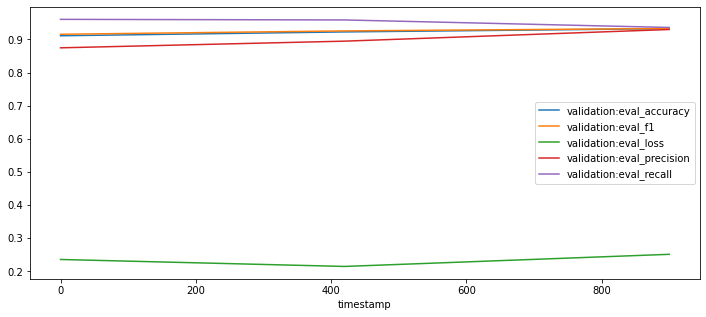

In [223]:
huggingface_estimator.plot_result()

### plot 1 metric

,timestamp,validation:eval_accuracy,validation:eval_f1,validation:eval_loss,validation:eval_precision,validation:eval_recall
0,0.0,0.9109,0.915425,0.236058,0.874501,0.960366
1,420.0,0.9225,0.925488,0.215057,0.894610,0.958574
2,900.0,0.9323,0.932804,0.251635,0.929759,0.935869


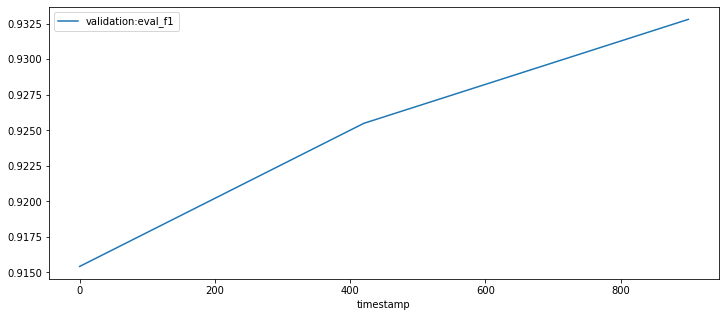

In [224]:
plot_result(huggingface_estimator,'validation:eval_f1')

### plot mutliple metrics

,timestamp,validation:eval_accuracy,validation:eval_f1,validation:eval_loss,validation:eval_precision,validation:eval_recall
0,0.0,0.9109,0.915425,0.236058,0.874501,0.960366
1,420.0,0.9225,0.925488,0.215057,0.894610,0.958574
2,900.0,0.9323,0.932804,0.251635,0.929759,0.935869


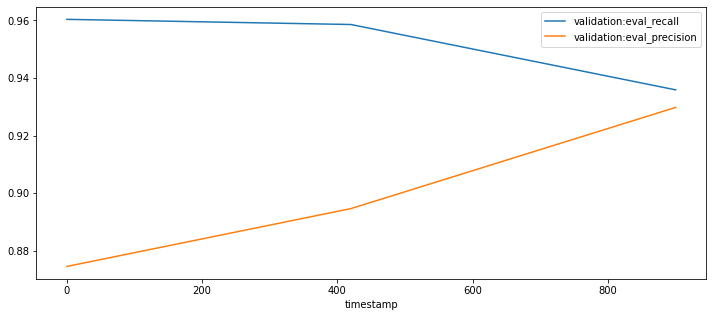

In [226]:
plot_result(huggingface_estimator,['validation:eval_recall','validation:eval_precision'])

# Estimator Parameters

### Get S3 url for model data

In [74]:
huggingface_estimator.model_data

's3://sagemaker-eu-central-1-558105141721/huggingface-sdk-extension-2020-12-27-15-25-50-506/output/model.tar.gz'

### Get latest training job name

In [75]:
huggingface_estimator.latest_training_job.name

'huggingface-sdk-extension-2020-12-27-15-25-50-506'

### Attach to old estimator 

e.g. to get model data

In [36]:
old_job_name='huggingface-sdk-extension-2020-12-27-15-25-50-506'

In [41]:
from sagemaker.estimator import Estimator

In [58]:
huggingface_estimator_loaded = Estimator.attach(old_job_name)


2020-12-27 15:34:03 Starting - Preparing the instances for training
2020-12-27 15:34:03 Downloading - Downloading input data
2020-12-27 15:34:03 Training - Training image download completed. Training in progress.
2020-12-27 15:34:03 Uploading - Uploading generated training model
2020-12-27 15:34:03 Completed - Training job completed


In [78]:
huggingface_estimator_loaded.model_data

's3://sagemaker-eu-central-1-558105141721/huggingface-sdk-extension-2020-12-27-15-25-50-506/output/model.tar.gz'

### Download model from s3

**using huggingface utils**

In [70]:
from huggingface.utils import download_model

download_model(model_data=huggingface_estimator_loaded.model_data,
               unzip=True,
               model_dir=huggingface_estimator_loaded.latest_training_job.name)

**using class built-in method**

In [ ]:
huggingface_estimator.download_model(unzip=False)

### Access logs

until [PR](https://github.com/aws/sagemaker-python-sdk/pull/2059) is merged

In [84]:
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name, wait=True)

2020-12-27 15:34:03 Starting - Preparing the instances for training
2020-12-27 15:34:03 Downloading - Downloading input data
2020-12-27 15:34:03 Training - Training image download completed. Training in progress.
2020-12-27 15:34:03 Uploading - Uploading generated training model
2020-12-27 15:34:03 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-12-27 15:32:15,198 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2020-12-27 15:32:15,221 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-12-27 15:32:18,249 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-12-27 15:32:18,802 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "tra

**after merged PR**

In [85]:
huggingface_estimator.logs()

ParamValidationError: Parameter validation failed:
Invalid type for parameter TrainingJobName, value: <sagemaker.estimator._TrainingJob object at 0x7ffc4af0d520>, type: <class 'sagemaker.estimator._TrainingJob'>, valid types: <class 'str'>